# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)
n = 1000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

In [5]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.084562834000841

### c)

In [8]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [9]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [11]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100

2/2 [==============================] - 1s 207ms/step - loss: 0.0082 - val_loss: -0.0126
Epoch 2/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0043 - val_loss: -0.0163
Epoch 3/100
2/2 [==============================] - 0s 35ms/step - loss: 7.1984e-04 - val_loss: -0.0195
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: -0.0023 - val_loss: -0.0221
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: -0.0057 - val_loss: -0.0246
Epoch 6/100
2/2 [==============================] - 0s 36ms/step - loss: -0.0090 - val_loss: -0.0274
Epoch 7/100
2/2 [==============================] - 0s 37ms/step - loss: -0.0123 - val_loss: -0.0300
Epoch 8/100
2/2 [==============================] - 0s 37ms/step - loss: -0.0148 - val_loss: -0.0323
Epoch 9/100
2/2 [==============================] - 0s 89ms/step - loss: -0.0175 - val_loss: -0.0342
Epoch 10/100
2/2 [==============================] - 0s 40ms/step - loss: -0.0197 - val_loss: -0.0

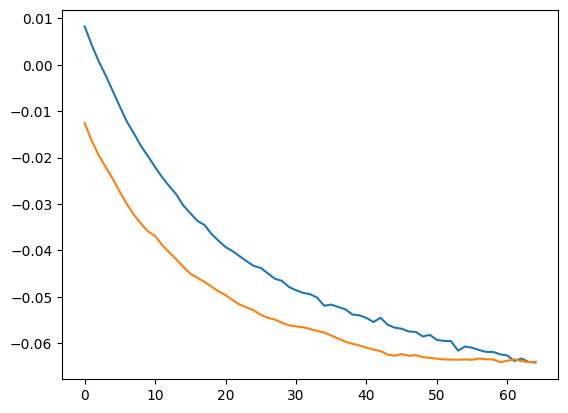

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [13]:
t_x_pred = model.predict(x)[:,0]

63/63 [==============================] - 0s 1ms/step


In [14]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

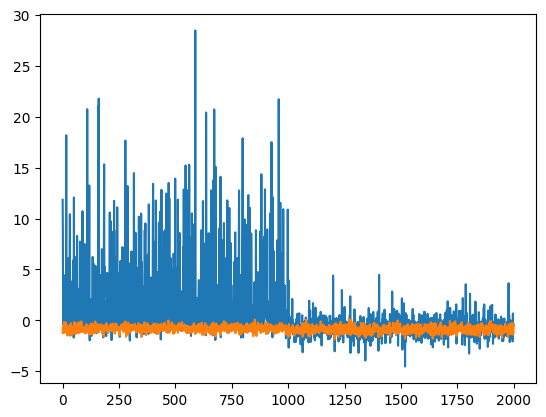

In [15]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

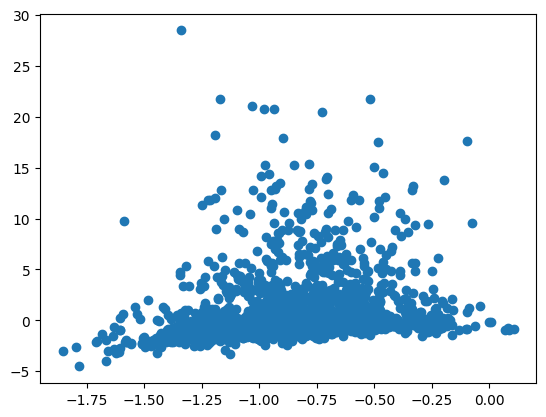

In [16]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [17]:
DV_fun(y, t_x_pred)

0.06422113854991873

In [18]:
DV_fun(y, t_x_opt)

2.084562834000841

In [19]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [20]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 [==============================] - 1s 1ms/step


### f)

In [21]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.math.exp(tf.subtract(T_x, tf.convert_to_tensor(1.0))), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2
    return -(first_term - second_term)

def NWJ_fun(y, t):
    return np.mean(t[y == 1]) - np.mean(np.exp(t[y == 0] - 1))

In [22]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [24]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
2/2 [==============================] - 1s 198ms/step - loss: 0.3980 - val_loss: 0.0110
Epoch 2/100
2/2 [==============================] - 0s 34ms/step - loss: -0.0011 - val_loss: 0.0028
Epoch 3/100
2/2 [==============================] - 0s 35ms/step - loss: -0.0068 - val_loss: -0.0026
Epoch 4/100
2/2 [==============================] - 0s 35ms/step - loss: -0.0108 - val_loss: -0.0076
Epoch 5/100
2/2 [==============================] - 0s 38ms/step - loss: -0.0143 - val_loss: -0.0121
Epoch 6/100
2/2 [==============================] - 0s 36ms/step - loss: -0.0172 - val_loss: -0.0153
Epoch 7/100
2/2 [==============================] - 0s 38ms/step - loss: -0.0188 - val_loss: -0.0186
Epoch 8/100
2/2 [==============================] - 0s 35ms/step - loss: -0.0223 - val_loss: -0.0231
Epoch 9/100
2/2 [==============================] - 0s 39ms/step - loss: -0.0252 - val_loss: -0.0271
Epoch 10/100
2/2 [==============================] - 0s 35ms/step - loss: -0.0279 - val_loss: -0.0300
E

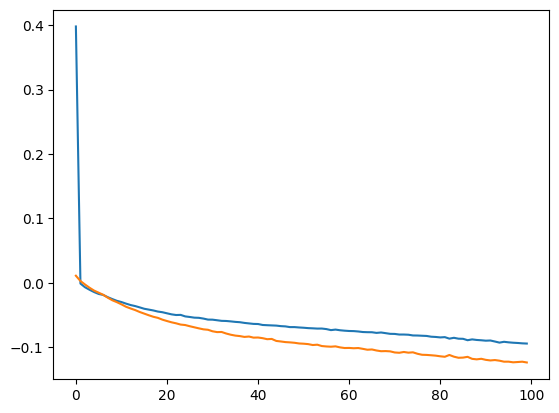

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [26]:
t_x_pred = model.predict(x)[:,0]

63/63 [==============================] - 0s 1ms/step


In [27]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

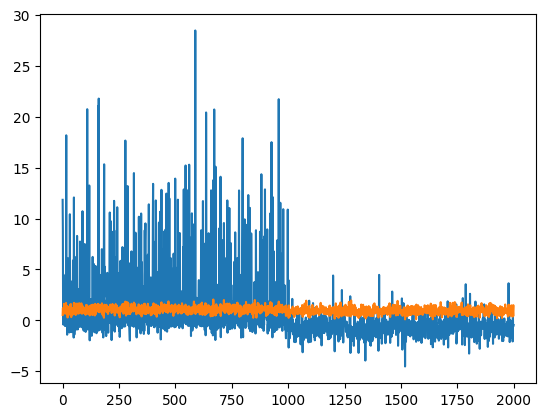

In [28]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

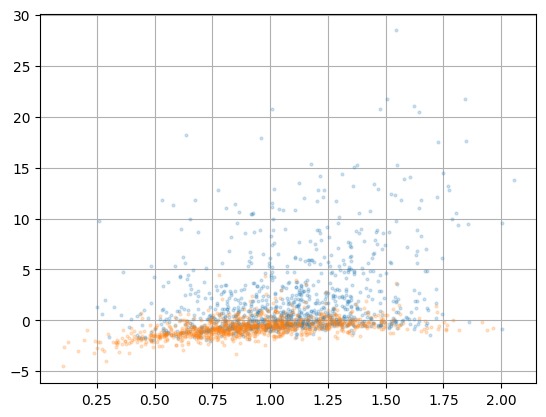

In [29]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

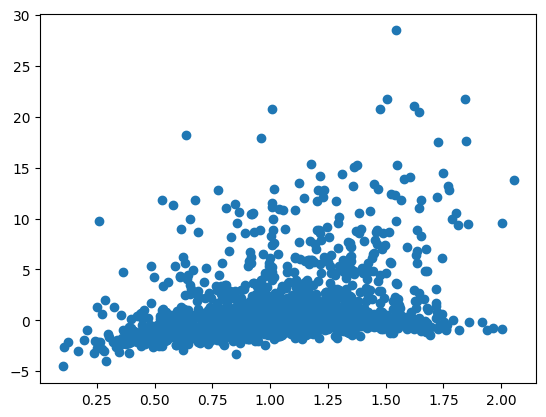

In [30]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [31]:
NWJ_fun(y, t_x_pred)

0.1023137

In [32]:
NWJ_fun(y, t_x_opt)

1.750338211363447

In [33]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [37]:
t_x_pred = model.predict(x_new)
t_x_opt = t_x_pred[:,0]

625/625 [==============================] - 1s 1ms/step


In [38]:
NWJ_fun(y_new, t_x_pred)

0.11323583

In [39]:
NWJ_fun(y_new, t_x_opt)

0.11323583